In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from patsy import dmatrices
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error



In [3]:
percentages_url = 'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId=20232024'
percentages_resp = requests.get(percentages_url)
percentages_json = percentages_resp.json()

In [4]:
df_percentages = DataFrame(percentages_json['data'])
df_percentages_filtered = df_percentages.loc[(df_percentages['positionCode'] != 'D') & (df_percentages['gamesPlayed'] >= 20)]
df_percentages_filtered = df_percentages_filtered.reset_index(drop=True)
df_percentages_filtered.drop(['skaterSavePct5v5', 'seasonId','shootingPct5v5', 'timeOnIcePerGame5v5', 'zoneStartPct5v5', 'satPercentage', 'satPercentageBehind', 'satPercentageAhead', 'satRelative', 'skaterShootingPlusSavePct5v5', 'usatPercentage', 'usatPercentageAhead', 'usatPercentageBehind', 'usatRelative'], axis=1, inplace=True)
df_percentages_filtered = df_percentages_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches','satPercentageClose',
 'satPercentageTied','usatPercentageTied', 'usatPrecentageClose']]

In [5]:
df_percentages_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.456,0.428,0.401,0.436
1,8480039,Martin Necas,Necas,C,CAR,82,R,0.610,0.621,0.601,0.597
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,78,L,0.434,0.441,0.438,0.435
3,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,L,0.509,0.503,0.487,0.490
4,8477989,Christian Dvorak,Dvorak,C,MTL,30,L,0.463,0.442,0.425,0.466
...,...,...,...,...,...,...,...,...,...,...,...
467,8477940,Nikolaj Ehlers,Ehlers,L,WPG,86,L,0.542,0.567,0.564,0.543
468,8480007,Jonas Rondbjerg,Rondbjerg,R,VGK,20,L,0.433,0.419,0.405,0.414
469,8479981,Jonah Gadjovich,Gadjovich,L,FLA,39,L,0.501,0.546,0.515,0.484
470,8482125,Alexander Holtz,Holtz,R,NJD,82,R,0.475,0.458,0.437,0.456


In [6]:
summary_url = 'https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId=20232024'
summary_resp = requests.get(summary_url)
summary_json = summary_resp.json()

In [7]:
df_summary = DataFrame(summary_json['data'])
df_summary_filtered = df_summary.loc[(df_summary['positionCode'] != 'D') & (df_summary['gamesPlayed'] >= 20)]
df_summary_filtered = df_summary_filtered.reset_index(drop=True)
df_summary_filtered.drop(['assists', 'evGoals', 'evPoints', 'faceoffWinPct', 'goals', 'penaltyMinutes', 'plusMinus', 'points', 'pointsPerGame', 'ppGoals', 'ppPoints', 'shPoints','shootingPct', 'shootsCatches', 'shots', 'timeOnIcePerGame', 'seasonId'], axis=1, inplace=True)
df_summary_filtered = df_summary_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'gameWinningGoals','otGoals', 'shGoals']]

In [8]:
df_summary_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,gameWinningGoals,otGoals,shGoals
0,8480039,Martin Necas,Necas,C,CAR,82,3,2,0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,1,0,0
2,8481624,Ilya Mikheyev,Mikheyev,R,VAN,82,1,0,0
3,8477508,Curtis Lazar,Lazar,C,NJD,71,2,0,1
4,8482062,Cole Smith,Smith,L,NSH,84,4,0,1
...,...,...,...,...,...,...,...,...,...
467,8477940,Nikolaj Ehlers,Ehlers,L,WPG,86,7,1,0
468,8480007,Jonas Rondbjerg,Rondbjerg,R,VGK,20,0,0,0
469,8479981,Jonah Gadjovich,Gadjovich,L,FLA,39,0,0,0
470,8482125,Alexander Holtz,Holtz,R,NJD,82,3,0,0


In [9]:
df_players_merged = pd.merge(df_percentages_filtered, df_summary_filtered, on = 'playerId')
df_players_merged.drop(['skaterFullName_y', 'lastName_y', 'positionCode_y', 'teamAbbrevs_y', 'gamesPlayed_y'], axis=1, inplace=True)
df_players_merged.columns = ['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']
df_players_merged = df_players_merged[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']]

In [10]:
percentages  = ['satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose']

for stat in percentages:
    df_players_merged[stat] *= 100

df_players_merged['teamAbbrevs'] = df_players_merged['teamAbbrevs'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)

In [11]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose,gameWinningGoals,otGoals,shGoals
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,45.6,42.8,40.1,43.6,1,0,0
1,8480039,Martin Necas,Necas,C,CAR,82,R,61.0,62.1,60.1,59.7,3,2,0
2,8481601,Simon Holmstrom,Holmstrom,R,NYI,78,L,43.4,44.1,43.8,43.5,3,0,5
3,8477402,Pavel Buchnevich,Buchnevich,L,STL,80,L,50.9,50.3,48.7,49.0,5,2,2
4,8477989,Christian Dvorak,Dvorak,C,MTL,30,L,46.3,44.2,42.5,46.6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,8477940,Nikolaj Ehlers,Ehlers,L,WPG,86,L,54.2,56.7,56.4,54.3,7,1,0
468,8480007,Jonas Rondbjerg,Rondbjerg,R,VGK,20,L,43.3,41.9,40.5,41.4,0,0,0
469,8479981,Jonah Gadjovich,Gadjovich,L,FLA,39,L,50.1,54.6,51.5,48.4,0,0,0
470,8482125,Alexander Holtz,Holtz,R,NJD,82,R,47.5,45.8,43.7,45.6,3,0,0


In [12]:
df_players_merged[['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose']].describe(percentiles=[0.75, 0.8, 0.9])

,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose
count,472.000000,472.000000,472.000000,472.000000
mean,49.335593,49.379025,49.443432,49.353602
std,4.826630,5.287188,5.432375,4.916715
min,35.700000,34.100000,34.700000,34.400000
50%,49.800000,49.700000,49.600000,49.700000
75%,52.525000,52.900000,53.325000,52.700000
80%,53.080000,53.780000,54.300000,53.380000
90%,55.300000,56.190000,56.290000,55.000000
max,62.300000,62.100000,63.200000,61.600000


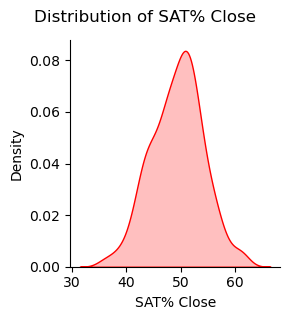

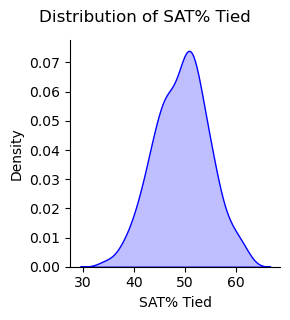

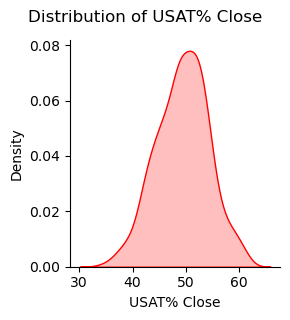

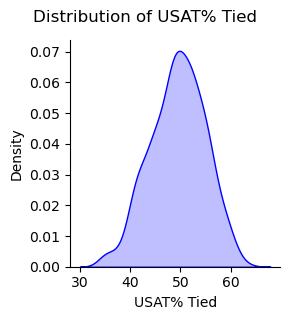

In [13]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageClose', fill=True, color='red')
satClose.fig.suptitle("Distribution of SAT% Close", y = 1.05)
satClose.set_xlabels("SAT% Close")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageTied', fill=True, color='blue')
satTied.fig.suptitle("Distribution of SAT% Tied", y = 1.05)
satTied.set_xlabels("SAT% Tied")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageClose', fill=True, color='red')
usatClose.fig.suptitle("Distribution of USAT% Close", y = 1.05)
usatClose.set_xlabels("USAT% Close")

usatTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageTied', fill=True, color='blue')
usatTied.fig.suptitle("Distribution of USAT% Tied", y = 1.05)
usatTied.set_xlabels("USAT% Tied")

In [14]:
df_players_merged[['gameWinningGoals', 'otGoals', 'shGoals']].describe(percentiles=[0.75, 0.8, 0.9])

,gameWinningGoals,otGoals,shGoals
count,472.000000,472.000000,472.000000
mean,2.228814,0.319915,0.449153
std,2.328303,0.678284,0.848102
min,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000
80%,4.000000,1.000000,1.000000
90%,5.000000,1.000000,2.000000
max,12.000000,3.000000,6.000000


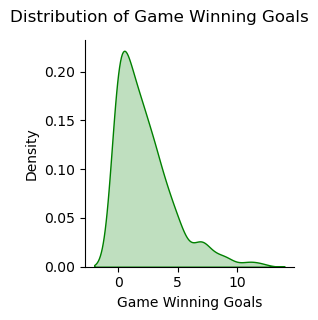

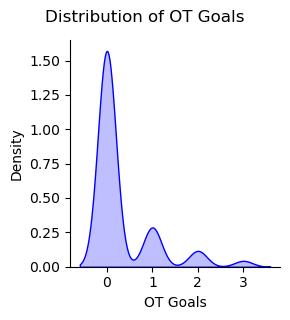

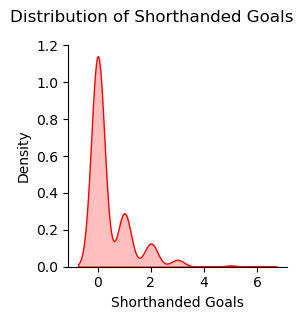

In [15]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'gameWinningGoals', fill=True, color='green')
satClose.fig.suptitle("Distribution of Game Winning Goals", y = 1.05)
satClose.set_xlabels("Game Winning Goals")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'otGoals', fill=True, color='blue')
satTied.fig.suptitle("Distribution of OT Goals", y = 1.05)
satTied.set_xlabels("OT Goals")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'shGoals', fill=True, color='red')
usatClose.fig.suptitle("Distribution of Shorthanded Goals", y = 1.05)
usatClose.set_xlabels("Shorthanded Goals")

In [16]:
satCloseMax = df_players_merged['satPercentageClose'].max()
satTiedMax = df_players_merged['satPercentageTied'].max()
usatCloseMax = df_players_merged['usatPercentageClose'].max()
usatTiedMax = df_players_merged['usatPercentageTied'].max()
usatTiedMax = df_players_merged['usatPercentageTied'].max()


def percentile_update(row): 
    return 

In [218]:
satCloseQuantile = df_players_merged['satPercentageClose'].quantile(0.9)
satTiedQuantile = df_players_merged['satPercentageTied'].quantile(0.9)
usatCloseQuantile = df_players_merged['usatPercentageClose'].quantile(0.9)
usatTiedQuantile = df_players_merged['usatPercentageTied'].quantile(0.9)
gameWinningGoalsQuantile = df_players_merged['gameWinningGoals'].quantile(0.8)

def binary_clutchness(row):
    clutchness = (row['satPercentageClose'] >= satCloseQuantile) or (row['satPercentageTied'] >= satTiedQuantile) or (row['usatPercentageClose'] >= usatCloseQuantile) or (row['usatPercentageTied'] >= usatTiedQuantile) and (row['gameWinningGoals'] >= gameWinningGoalsQuantile)
    if clutchness:
        return 1
    else:
        return 0
        
df_players_merged['clutch_performance'] = df_players_merged.apply(binary_clutchness, axis=1)

In [219]:
df_players_merged['clutch_performance'].value_counts()

clutch_performance
0    401
1     71
Name: count, dtype: int64

In [247]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.35)
model = RandomForestClassifier(n_estimators=100)
model.fit(train[x_var], train[y_var].values.ravel())

test['clutch_type'] = model.predict(test[x_var])
test['correct'] = (test['clutch_type'] == test['clutch_performance'])

test['correct'].mean()

0.9819277108433735

In [248]:
scores = cross_val_score(model, df_players_merged[x_var], df_players_merged[y_var].values.ravel(), cv=10)
scores

array([1.        , 1.        , 1.        , 1.        , 0.95744681,
       0.95744681, 1.        , 0.9787234 , 1.        , 1.        ])

In [249]:
scores.mean()

0.9893617021276595

In [250]:
probs = model.predict_proba(test[x_var])[:, 1]

roc_auc = roc_auc_score(test[y_var], probs)

roc_auc

0.9994824016563146

In [251]:
y_pred = model.predict(test[x_var])  
y_true = test[y_var]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 1.0
Recall: 0.8928571428571429
F1 Score: 0.9433962264150945


In [252]:
probs = model.predict_proba(test[x_var])[:, 1]

auc_pr = average_precision_score(test[y_var], probs)

auc_pr

0.9976190476190476

In [253]:
predicted_classes = model.predict(test[x_var])
mcc = matthews_corrcoef(y_true, predicted_classes)
mcc

0.9348048900015558

<Axes: >

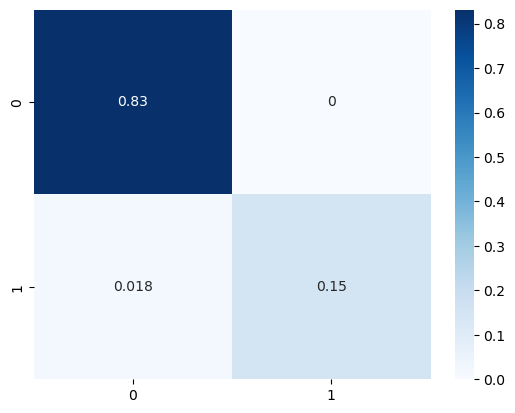

In [254]:
conf_matrix = confusion_matrix(y_true, y_pred, normalize="all")

conf_matrix

sns.heatmap(conf_matrix, cmap="Blues", annot=True)

In [255]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
accuracy

0.9819277108433735

In [256]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

train, test = train_test_split(df_players_merged, test_size=0.35)

class_weights = compute_class_weight('balanced', classes=train[y_var].unique(), y=train[y_var])

model = RandomForestClassifier(n_estimators = 100, class_weight = dict(zip(train[y_var].unique(), class_weights)))
model.fit(train[x_var], train[y_var])

accuracy = model.score(test[x_var], test[y_var])
print("Accuracy:", accuracy)


Accuracy: 0.9819277108433735


In [259]:
dict(zip(train[y_var].unique(), class_weights))

{1: 3.25531914893617, 0: 0.5907335907335908}

In [257]:
mse = mean_squared_error(y_true, y_pred)

mse

0.018072289156626505